### This implements Convolutional Neural Fabric (Shreyas Saxena, Jakob Verbeek, NIPS 16), a 3D trellis-shaped graph "that embeds an exponentially large number of [convolutional network] architectures" and abstracts away the problem of handcrafting "a single optimal architecture."

The original implementation uses Matlab to generate a Caffe network (prototext file). To the best of our knowledge, this is the first and only Keras/TensorFlow implementation so far.

- Original paper: https://arxiv.org/abs/1606.02492.

- Original implementation: https://github.com/shreyassaxena/convolutional-neural-fabrics

-- Rishabh Kabra (rishabhkabra@gmail.com)

In [2]:
"""We implement here the basic Fabric design prescribed 
in the paper: CNF-dense with constant channels per scale.

The only hyperparameters to this architecture are: number of 
layers, channels, scales, and the size of the convolution kernel.
The size of the kernel is constant throughout the Fabric.
The number of scales can, in fact, be autoset to reduce images 
to the coarsest resolution (1x1) on the last scale.

Scale indices [0,1,..., num_scales-1] go from the 
highest resolution to the lowest resolution.
An edge from a lower-index scale to a higher-index scale 
requires downsampling. We avoid max/average-pooling layers 
to downsample, preferring ReLU units and strided convolutions 
instead, as per the generalization results in the paper.
Likewise, an edge from a higher-index scale to a 
lower-index requires upsampling: we repeat activations
from the coarser level using the standard Keras implementation.

After sizing, we apply batch normalization and a ReLU activation 
on each edge in the trellis.
"""

__author__ = 'Rishabh Kabra'
__email__ = 'rishabhkabra@gmail.com'

from keras.models import Model, Sequential
from keras.layers import Input, Convolution2D, Activation, Flatten, Merge, Dense
from keras.layers.merge import Add
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.layers.normalization import BatchNormalization

num_channels = 16
num_scales = 5
num_layers = 4

input_dim = 32,32,3
inp = Input(input_dim)

kernel_size = 3

def Upsample(input_shape, out_channels):
    """
    Initialize a Fabric edge from a low-resolution scale
    to the adjacent higher resolution, in the same layer 
    or between adjacent layers
    """
    model = Sequential()
    model.add(UpSampling2D(size=(2, 2), input_shape=input_shape))
    model.add(Conv2D(out_channels, kernel_size, strides=(1, 1), padding='same'))
    model.add(BatchNormalization(momentum=0.1))
    model.add(Activation('relu'))
    return model
    
def Downsample(input_shape, out_channels):
    """
    Initialize a Fabric edge from a high-resolution scale
    to the adjacent lower resolution, in the same layer 
    or between adjacent layers
    """
    model = Sequential()
    model.add(Conv2D(out_channels, kernel_size, strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(BatchNormalization(momentum=0.1))
    model.add(Activation('relu'))
    return model
    
def SameRes(input_shape, out_channels):
    """
    Initialize a Fabric edge between scales of the same
    resolution, between adjacent layers
    """
    model = Sequential()
    model.add(Conv2D(out_channels, kernel_size, strides=(1, 1), padding='same', input_shape=input_shape))
    model.add(BatchNormalization(momentum=0.1))
    model.add(Activation('relu'))
    return model

fabric = {}
# Each fabric[layer][scale] value is a list of Downsample/Upsample/SameRes modules, 
# representing all edges that may emerge from the Fabric node at [layer, scale].

# Init: initialize all required edges at each node
for layer in range(num_layers):
    fabric[layer] = {}
    for scale in range(num_scales):
        input_shape = (input_dim[0]/int(2**scale), input_dim[1]/int(2**scale), num_channels)
        if layer == 0:
            fabric[layer][scale] = [Downsample(input_shape, num_channels)]
        else:
            input_shape = (32/int(2**scale), 32/int(2**scale), num_channels)
            fabric[layer][scale] = [SameRes(input_shape, num_channels)]
            if scale == 0:
                fabric[layer][scale].append(Upsample(input_shape, num_channels))
            elif scale < num_scales - 1:
                fabric[layer][scale].append(Downsample(input_shape, num_channels))
                fabric[layer][scale].append(Upsample(input_shape, num_channels))
                if layer == num_layers - 1:
                    fabric[layer][scale].append(Downsample(input_shape, num_channels))
            else:
                fabric[layer][scale].append(Downsample(input_shape, num_channels))
                if layer == num_layers - 1:
                    fabric[layer][scale].append(Downsample(input_shape, num_channels))
                
# Activations
input_edge = SameRes(input_dim, num_channels) # edge from input into the Fabric
init = input_edge(inp) # to be used as initial activation
activation = {}
for layer in range(num_layers):
    activation[layer] = {}
    for scale in range(num_scales):
        if layer == 0:
            if scale == 0:
                activation[layer][scale] = fabric[layer][scale][0](init)
            else:
                activation[layer][scale] = fabric[layer][scale][0](activation[layer][scale-1])
        else:
            if scale == 0:
                to_merge = []
                to_merge.append(activation[layer-1][scale])
                to_merge.append(fabric[layer][scale][1](activation[layer-1][scale+1]))
            elif scale < num_scales-1:
                to_merge = []
                to_merge.append(activation[layer-1][scale])
                to_merge.append(fabric[layer][scale][2](activation[layer-1][scale+1]))
                to_merge.append(fabric[layer][scale][1](activation[layer-1][scale-1]))
                if layer == num_layers-1:
                    to_merge.append(fabric[layer][scale][3](activation[layer][scale-1]))
            else:
                to_merge = []
                to_merge.append(activation[layer-1][scale])
                to_merge.append(fabric[layer][scale][1](activation[layer-1][scale-1]))
                if layer == num_layers-1:
                    to_merge.append(fabric[layer][scale][2](activation[layer][scale-1]))
            add_merged_inp = Add()(to_merge)
            activation[layer][scale] = fabric[layer][scale][0](add_merged_inp)

# Final output from the Fabric
out = activation[num_layers-1][num_scales-1]
out = Flatten()(out)
out = Activation('softmax')(Dense(10)(out))

model = Model(input=inp, output=out)  
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 32, 32, 3)     0                                            
____________________________________________________________________________________________________
sequential_109 (Sequential)      (None, 32, 32, 16)    512                                          
____________________________________________________________________________________________________
sequential_61 (Sequential)       (None, 16, 16, 16)    2384                                         
____________________________________________________________________________________________________
sequential_62 (Sequential)       (None, 8, 8, 16)      2384                                         
___________________________________________________________________________________________

/home/risha/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:142: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ac..., inputs=Tensor("in...)`


The final number of trainable parameters in our CNF-dense model, with 5 scales, 4 layers, and 16 channels, is 88k. As per Table 12 in the original paper, the CNF authors report 166k params in their model. We have half as many parameters as them. In the original paper, the number of scales is fixed at 1+log_2(dim_of_image) = 1+log_2(32) = 6.

### Training

We fit the Fabric model using the Adam optimizer on all 50000 CIFAR10 training samples. We use a cross-entropy loss and train for accuracy. The images are pre-processed as in the paper: they can be randomly flipped horizontally or translated in either direction. We trained for 1000 epochs previously, but on this rerun we restrict ourselves to 100 epochs in the interest of time. The fitted model is saved as 'fabric_cifar10.h5' in the parent directory of this notebook.

In [ ]:
"""
This module is nearly identical to the CIFAR10 example 
in the keras package: see
https://github.com/fchollet/keras/blob/master/examples/cifar10_cnn.py
"""

__author__ = 'Rishabh Kabra'
__email__ = 'rishabhkabra@gmail.com'


from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam
from keras.utils import np_utils

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print 'X_train shape:', X_train.shape
print X_train.shape[0], 'train samples'
print X_test.shape[0], 'test samples'

batch_size = 50
nb_classes = 10
nb_epoch = 100
data_augmentation = True

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

sgd = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

if not data_augmentation:
    print 'Not using data augmentation.'
    model.fit(X_train, Y_train,
              batch_size=batch_size,
              nb_epoch=nb_epoch,
              validation_data=(X_test, Y_test),
              shuffle=True)

else:
    print 'Using real-time data augmentation.'

    # preprocessing and realtime data augmentation
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    datagen.fit(X_train)

    # fit the model on the batches generated by datagen.flow()
    model.fit_generator(datagen.flow(X_train, Y_train,
                        batch_size=batch_size),
                        samples_per_epoch=X_train.shape[0],
                        nb_epoch=nb_epoch,
                        validation_data=(X_test, Y_test),
                        verbose=2)
model.save('fabric_cifar10.h5')

X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Using real-time data augmentation.


/home/risha/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:62: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., verbose=2, validation_data=(array([[[..., steps_per_epoch=1000, epochs=100)`


Epoch 1/100
179s - loss: 2.0613 - acc: 0.2478 - val_loss: 1.8119 - val_acc: 0.3490
Epoch 2/100
165s - loss: 1.7353 - acc: 0.3672 - val_loss: 1.5938 - val_acc: 0.4236
Epoch 3/100
166s - loss: 1.5939 - acc: 0.4153 - val_loss: 1.4873 - val_acc: 0.4577
Epoch 4/100
165s - loss: 1.5061 - acc: 0.4517 - val_loss: 1.4220 - val_acc: 0.4772
Epoch 5/100
166s - loss: 1.4390 - acc: 0.4737 - val_loss: 1.3473 - val_acc: 0.5064
Epoch 6/100
165s - loss: 1.3860 - acc: 0.4970 - val_loss: 1.2928 - val_acc: 0.5325
Epoch 7/100
165s - loss: 1.3395 - acc: 0.5147 - val_loss: 1.2666 - val_acc: 0.5377
Epoch 8/100
164s - loss: 1.3014 - acc: 0.5278 - val_loss: 1.2388 - val_acc: 0.5539
Epoch 9/100
164s - loss: 1.2649 - acc: 0.5420 - val_loss: 1.2149 - val_acc: 0.5629
Epoch 10/100
164s - loss: 1.2365 - acc: 0.5531 - val_loss: 1.2123 - val_acc: 0.5616
Epoch 11/100
164s - loss: 1.2082 - acc: 0.5650 - val_loss: 1.1395 - val_acc: 0.5840
Epoch 12/100
164s - loss: 1.1770 - acc: 0.5759 - val_loss: 1.1335 - val_acc: 0.5944
E

We plot training history below.

In [8]:
hist.history.keys()

['acc', 'loss', 'val_acc', 'val_loss']

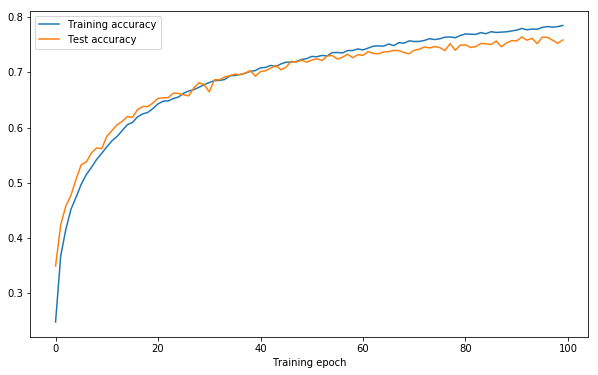

In [22]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(hist.history['acc'], label='Training accuracy')
ax.plot(hist.history['val_acc'], label='Test accuracy')
ax.set_xlabel('Training epoch')
plt.legend()
plt.show()

The model continues to gain accuracy on the test data through 100 epochs. When we ran 1000 epochs previously (no early stopping), we recorded a test accuracy maxima of about .80, which was very close to the 19.22% error rate recorded in the paper for 4 layers and 16 channels (Table 10).

We recheck the accuracy achieved on the test set below:

In [4]:
from scipy.special import expit
import numpy as np
pred = model.predict(X_test)
classes_pred = np.argmax(expit(pred), axis=1)
classes = np.argmax(Y_test, axis=1)
print "Accuracy:", 1.*np.sum(classes_pred == classes)/classes.shape[0]

Accuracy: 0.7586


### Pending work:

Visualize weight of paths through the fabric.

Try a higher res dataset, maybe ImageNet?

Fit a deconvolutional network. Can it be trained adversarially?

Test against other meta-learners that can optimize over a space of convolutional architectures:
- Bowen Baker, Otkrist Gupta, Nikhil Naik, and Ramesh Raskar. Designing Neural Network Architectures using Reinforcement Learning. In ICLR '17: https://openreview.net/forum?id=S1c2cvqee. Use Q-learning with epsilon-greedy exploration strategy and experience replay. Trained on image classification tasks with 10 GPUs.
- Barret Zoph and Quoc Le. Neural Architecture Search with Reinforcement Learning. In ICLR '17: https://openreview.net/forum?id=r1Ue8Hcxg. Higher scores and more thorough results than previous paper, but infrastructural requirements may make this infeasible to reproduce.